In [6]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# Path to your 4-channel forest/woodland file
audio_path = "C:/Users/simor/Documents/ICA_Project/data/EigenScape/Woodland/Woodland.1.wav"  # <-- adjust

data, sr_forest = sf.read(audio_path)   # data: (T, n_channels) usually

print("Raw data shape:", data.shape)
print("Sample rate:", sr_forest)

# Ensure it's 4 channels
if data.ndim == 1:
    raise ValueError("This file is mono! You need a multichannel file.")
n_samples, n_channels = data.shape
print("n_samples:", n_samples, "n_channels:", n_channels)

# Use only first 4 channels if there are more
n_mics = min(4, n_channels)
audio_forest = data[:, :n_mics]  # (T, n_mics)
print("audio_forest shape:", audio_forest.shape)

Raw data shape: (28800000, 25)
Sample rate: 48000
n_samples: 28800000 n_channels: 25
audio_forest shape: (28800000, 4)


In [7]:
duration_sec = 15
N_forest = min(n_samples, duration_sec * sr_forest)

audio_seg = audio_forest[:N_forest, :]   # (N_forest, n_mics)
print("Segment shape:", audio_seg.shape)

# Center each channel
audio_seg_centered = audio_seg - audio_seg.mean(axis=0, keepdims=True)
print("Centered segment shape:", audio_seg_centered.shape)


Segment shape: (720000, 4)
Centered segment shape: (720000, 4)


In [8]:
import pyroomacoustics as pra
import librosa

audio = audio_seg_centered   # rename for reuse
N_forest, n_mics = audio.shape
print("audio shape:", audio.shape)

# STFT parameters
fft_size = 2048
hop = fft_size // 2
window = "hann"

# 1) STFT per channel: X_stft: (frames, freqs, mics)
stft_list = []

for ch in range(n_mics):
    S = librosa.stft(audio[:, ch],
                     n_fft=fft_size,
                     hop_length=hop,
                     window=window)
    stft_list.append(S.T)  # (frames, freqs)

X_stft = np.stack(stft_list, axis=-1)
print("X_stft shape (frames, freqs, mics):", X_stft.shape)

# 2) AuxIVA
n_src = n_mics
Y = pra.bss.auxiva(X_stft, n_src=n_src, n_iter=30)  # a bit more iterations
print("Y shape (frames, freqs, sources):", Y.shape)

# 3) iSTFT for each separated source
sep_signals = []
n_frames, n_freqs, n_src = Y.shape

for i in range(n_src):
    Y_i = Y[:, :, i].T   # (freqs, frames)
    y_i = librosa.istft(Y_i,
                        hop_length=hop,
                        window=window)
    sep_signals.append(y_i)

min_len = min(len(y) for y in sep_signals)
sep_signals = np.stack([y[:min_len] for y in sep_signals], axis=-1)  # (T, n_src)
print("Separated time-domain shape:", sep_signals.shape)


audio shape: (720000, 4)
X_stft shape (frames, freqs, mics): (704, 1025, 4)
Y shape (frames, freqs, sources): (704, 1025, 4)
Separated time-domain shape: (719872, 4)


In [9]:
from IPython.display import Audio

def play_forest_mic(i):
    print(f"Playing raw forest mic {i}")
    return Audio(audio[:, i], rate=sr_forest)

def play_forest_sep(i):
    print(f"Playing separated forest source {i}")
    return Audio(sep_signals[:, i], rate=sr_forest)

# Example:
play_forest_mic(0) # Mixture
# then:
# play_forest_sep(1)
# play_forest_sep(2)  # Footsteps !!
# play_forest_sep(3)


Playing raw forest mic 0


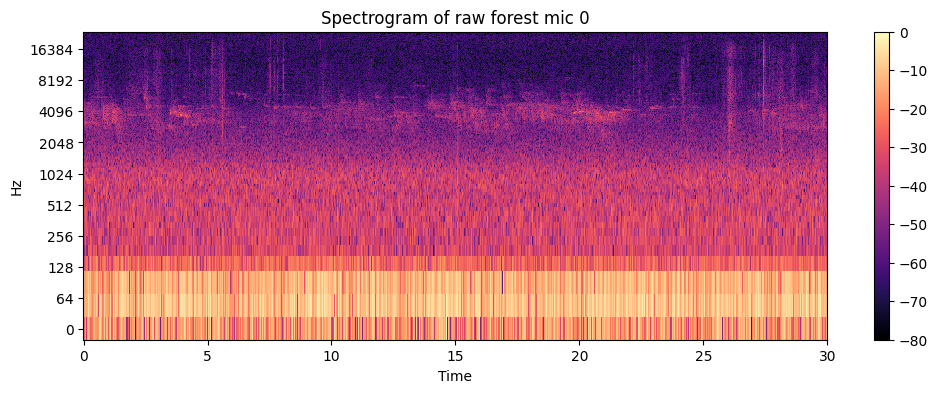

In [10]:
raw = audio[:, 0]
D_raw = librosa.amplitude_to_db(
    np.abs(librosa.stft(raw, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D_raw, sr=sr_forest, x_axis='time', y_axis='log')
plt.title("Spectrogram of raw forest mic 0")
plt.colorbar()
plt.show()


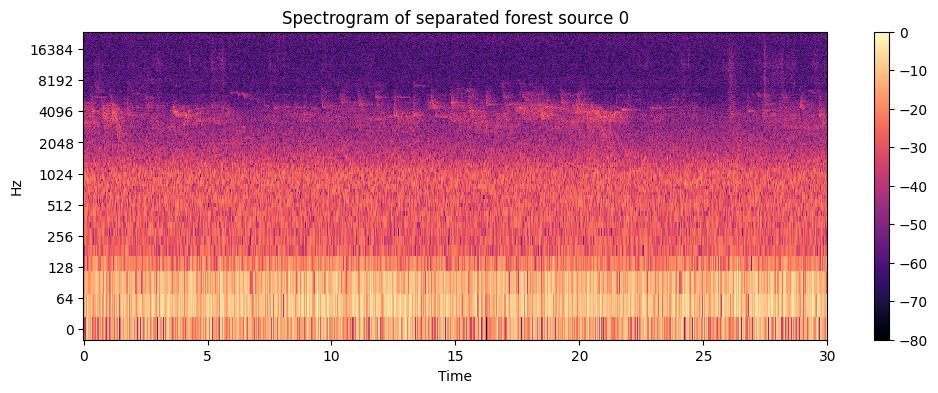

In [11]:
import librosa.display
import matplotlib.pyplot as plt

src_idx = 0  # try 0,1,2,3
sep = sep_signals[:, src_idx]

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(sep, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr_forest, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of separated forest source {src_idx}")
plt.colorbar()
plt.show()


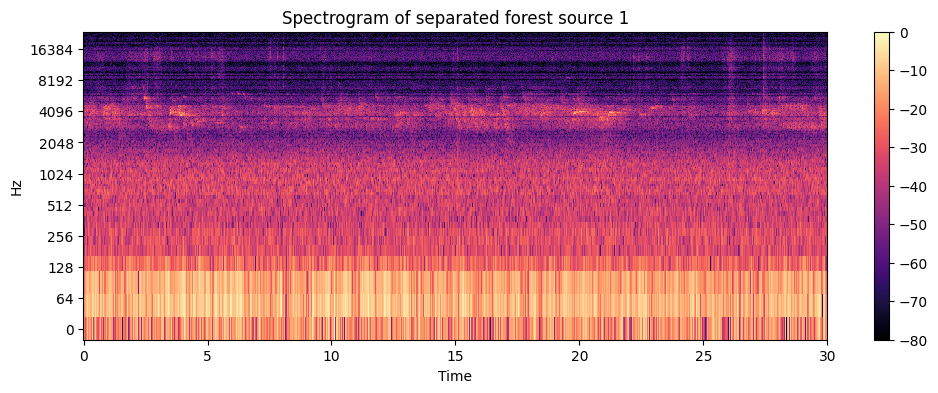

In [12]:
import librosa.display
import matplotlib.pyplot as plt

src_idx = 1  # try 0,1,2,3
sep = sep_signals[:, src_idx]

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(sep, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr_forest, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of separated forest source {src_idx}")
plt.colorbar()
plt.show()

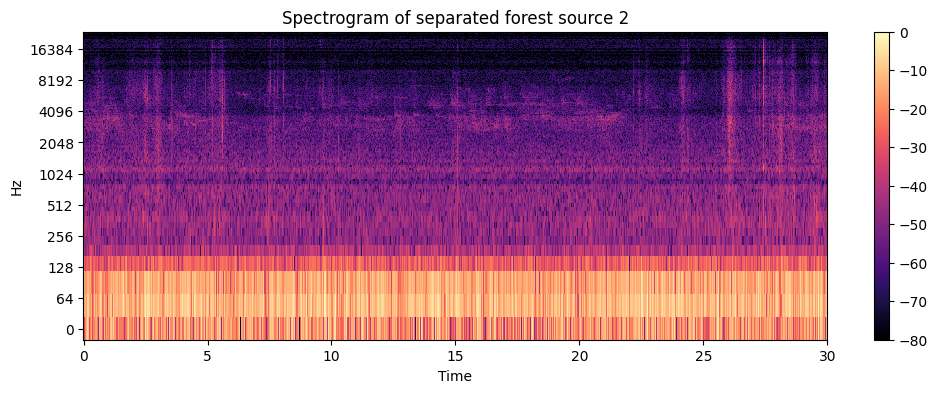

In [13]:
import librosa.display
import matplotlib.pyplot as plt

src_idx = 2  # try 0,1,2,3
sep = sep_signals[:, src_idx]

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(sep, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr_forest, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of separated forest source {src_idx}")
plt.colorbar()
plt.show()

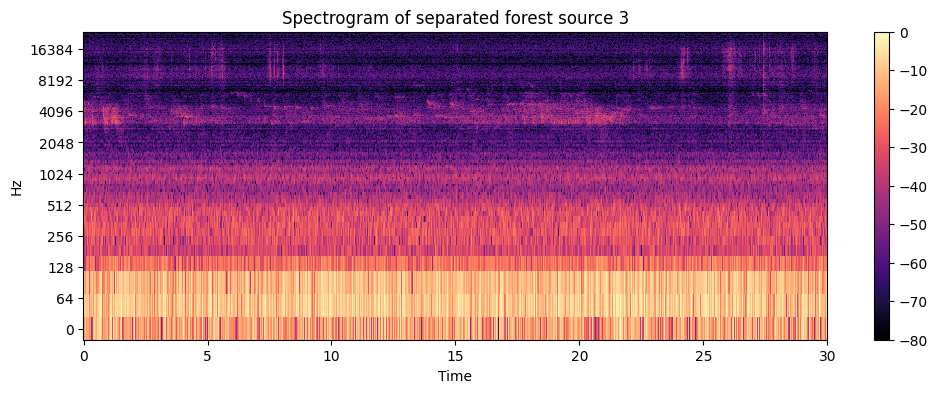

In [14]:
import librosa.display
import matplotlib.pyplot as plt

src_idx = 3  # try 0,1,2,3
sep = sep_signals[:, src_idx]

D = librosa.amplitude_to_db(
    np.abs(librosa.stft(sep, n_fft=1024, hop_length=256)),
    ref=np.max
)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr_forest, x_axis='time', y_axis='log')
plt.title(f"Spectrogram of separated forest source {src_idx}")
plt.colorbar()
plt.show()

In [ ]:
# Correlation between components and original channels (10s segment)
corr = np.corrcoef(Y, Y)  # matrix of size (16+16, 16+16)

# Extract block: components vs channels
comp_vs_chan = corr[:8, :8]

plt.figure(figsize=(8, 6))
plt.imshow(comp_vs_chan, aspect='auto', cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xlabel("Original Channels")
plt.ylabel("ICA Components")
plt.title("Correlation between ICA components and original channels")
plt.show()

ValueError: m has more than 2 dimensions